<a href="https://colab.research.google.com/github/Facusc16/data_flow/blob/main/Data_%26_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requerimientos

## Librerías

Se utilizó la versión 1.5.1 de la librería scikit-learn para entrenar el modelo de clasificación

In [ ]:
!pip install spotipy
# !pip install scikit-learn==1.5.1

In [ ]:
# Ciencia de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

# Google Colab
# from google.colab import drive

# Spotify
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException

# Exceptions Warnings
from requests.exceptions import RequestException
import warnings

# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, precision_score, recall_score,  f1_score, log_loss

from joblib import dump, load
from IPython.display import clear_output
import logging
import sys
import re
import json
import time
from datetime import timedelta
import os

## Google Drive

Primera mente fue utilizado google colab conectado a un entorno de ejecución alojado para trabajar con el dataset, luego se utilizó un entorno de ejecución local para facilitar el entrenamiento del modelo de clasificación.

In [ ]:
# drive.mount('/content/drive')

## Construir DataFrame

In [ ]:
path = 'spotify_dataset.csv'

df = pd.read_csv(path)

# Analisis descriptivo

## Dimensiones del DataFreme

In [ ]:
df.shape

(498052, 39)

## Información general del DataFrame

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498052 entries, 0 to 498051
Data columns (total 39 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Artist(s)                       498052 non-null  object 
 1   song                            498038 non-null  object 
 2   text                            498052 non-null  object 
 3   Length                          498052 non-null  object 
 4   emotion                         498052 non-null  object 
 5   Genre                           498052 non-null  object 
 6   Album                           498003 non-null  object 
 7   Release Date                    350369 non-null  object 
 8   Key                             498052 non-null  object 
 9   Tempo                           498052 non-null  float64
 10  Loudness (db)                   498052 non-null  float64
 11  Time signature                  498044 non-null  object 
 12  Explicit        

# Limpieza y manipulación de los datos

## Quitar datos duplicados o irrelevantes

In [ ]:
df.duplicated().any()

False

## Arreglar errores estructurales

In [ ]:
df.head()

,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,03:47,sadness,hip hop,Thr!!!er,2013-04-29,D min,0.437870,...,0,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",04:03,sadness,hip hop,Thr!!!er,2013-04-29,A# min,0.508876,...,0,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",05:51,joy,hip hop,Louden Up Now,2004-06-08,A Maj,0.532544,...,0,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752
3,!!!,Ooo,[Verse 1] Remember when I called you on the te...,03:44,joy,hip hop,As If,2015-10-16,A min,0.538462,...,0,Eric Clapton,Man Overboard,0.992749,Roxette,Don't Believe In Accidents,0.991494,Tiwa Savage,My Darlin,0.990381
4,!!!,Freedom 15,[Verse 1] Calling me like I got something to s...,06:00,joy,hip hop,As If,2015-10-16,F min,0.544379,...,0,Cibo Matto,Lint Of Love,0.981610,Barrington Levy,Better Than Gold,0.981524,Freestyle,Its Automatic,0.981415


In [ ]:
df.tail()

,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
498047,박혜진 Park Hye Jin,Can you,Can you be my (Can you be my) Can you be my (C...,03:39,joy,house,Can you (Galcher Lustwerk Remix),2020-10-14,B min,0.644970,...,0,LXST CXNTURY,NEVER EXISTED,0.946429,"Occvlt,StoneDogg",ALIZAY,0.926155,Peaches,Light in Places,0.923749
498048,심형진 Hyungjin Sim,Lim Han Byul Lee Hyuk - Prayer English Transl...,[Verse] I gave you my everything But I see I c...,08:47,joy,metalcore,비 준비하시니 Psalm_147,2022-04-19,G# Maj,0.573964,...,0,Kari Jobe,No Fear Live,0.991961,"The Belonging Co,Kari Jobe",Closer To Your Heart,0.990956,Saintseneca,Pillar of Na,0.990385
498049,우정하,Memories Smiling Tears Remix,"[Tasha] Hell on earth, watching ...",03:53,sadness,hip hop,MEMORY,2023-08-30,G# min,0.260355,...,0,Manic Street Preachers,People Give In,0.982809,Vinyl Theatre,Gold,0.980835,Unspoken,Life in the Death of Me,0.980171
498050,제노,Come Back to Me,[Verse] Gifts and flowers lay upon the lid Of ...,03:12,sadness,hip hop,2008 to me again,NaN,E Maj,0.562130,...,0,Bonnie Raitt,I Can't Help Myself,0.983805,J. Roddy Walston & The Business,Bad Habits,0.982425,Idina Menzel,Damsel In Distress,0.975935
498051,코케,I Wanna Be With You,I wanna b with you I wanna b with you baby Yea...,03:32,love,hip hop,I Wanna Be With You : Originally Performed By ...,2020-11-04,D Maj,0.408284,...,0,Ameritz - Karaoke,Roxanne 97 Puff Daddy Remix,0.987132,Ameritz - Karaoke,Roxanne,0.987132,ProSource Karaoke,Get Back Single Version,0.984674


In [ ]:
df.sample(5)

,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
365749,Russ,Army,[Verse] Who's this dude who's rappin' crazy? M...,02:25,joy,hip hop,Silence,2014-06-11,B Maj,0.295858,...,0,Home Brew,Thursday,0.982366,Home Brew,Tierstar Vs. Dizaster,0.982366,SosMula,GUN SPORT,0.975853
140237,Extreme,Am I Ever Gonna Change,"I'm tired of being me, And I don't like wha...",06:56,sadness,"progressive rock,grunge,hard rock",III Sides To Every Story,NaN,C# Maj,0.349112,...,0,Marillion,You're Gone,0.962822,Bob Dylan,Narrow Way,0.954257,Bruce Springsteen,Worlds Apart,0.954137
48932,"Bizzle,Sevin",My Confession,[Verse 1: Bizzle] I'm so tired of the fake thi...,04:33,joy,hip hop,The Good Fight,2013-05-07,E min,0.325444,...,0,Flo Rida,Make A Wish,0.974739,"Mogli the Iceburg,Reconcile",Put My Life On This,0.968846,"Serious Klein,FARR",God Is Love,0.968494
143917,Feed Me Jack,Audio Pono,[Verse 1] Charged and on the wing Unperturbed ...,04:46,sadness,math rock,Ultra Ego,2016-01-20,C# Maj,0.562130,...,0,Gileah Taylor,Going Home,0.985922,Luther Vandross,Isn't There Someone,0.984809,The Districts,Silver Couplets,0.984623
396090,"SPINALL,Olamide",Gimme Luv,"[Intro – Olamide:] Oh my baby girl, baby girl ...",03:22,sadness,hip hop,Gimme Luv (feat. Olamide),2017-04-06,D Maj,0.467456,...,0,"Tom Gregory,Sebastien",Losing Sleep,0.976838,Donnie Klang,Just a Rolling Stone,0.975389,Psycho Maadnbad,Sorry Im Bad,0.974072


### Definir errores

#### Cambiar nombres de columnas a minúsculas, y reemplazar espacios y carácteres especiales

In [ ]:
trans = str.maketrans({
    " ": "_",
    "/": "_",
    "(": "",
    ")": ""
})

columns = {}
for column in df.columns:
  columns[column] = column.strip().lower().translate(trans)

df.rename(columns=columns, inplace=True)

#### Separar "Artists" en distintas filas

In [ ]:
# Encontré esta fila posteriormente, "Clifton Davins," estaba creando una fila más al hacer .split(), .explode() por tener una coma de más.
df.loc[469650, 'artists'] = 'Vanessa Bell Armstrong, Sandra Crouch, Patti Austin, Daryl Coley, Commissioned, Clifton Davis, Bernie K., Andrae Crouch'

In [ ]:
df['artists'] = df['artists'].str.split(r',|;')

In [ ]:
df = df.explode('artists').reset_index(drop=True)

#### Separar "genre" en distintas filas

In [ ]:
df['genre'] = df['genre'].str.split(",")

In [ ]:
df = df.explode('genre').reset_index(drop=True)

#### Eliminar espacios extras de columnas tipo object

In [ ]:
for col in df.select_dtypes(include='object'):
  if len(df[df[col].notna() & (df[col].str.strip() != df[col])]) != 0:
    df[col] = df[col].str.strip()

#### Reemplazar strings vacios en 'artists'

In [ ]:
artists = ['Chhrmng,', 'Desconocido', 'Desconocido', 'Desconocido']
for i, index in enumerate(df[df['artists'].apply(lambda x: x.strip() == '')].index):
  df.loc[index, 'artists'] = artists[i]

#### Convertir a minúscula "text" y "emotion"

In [ ]:
df['text'] = df['text'].str.lower()

In [ ]:
df['emotion'] = df['emotion'].str.lower()

#### Convertir "length" a timedelta

In [ ]:
df['length'] = df['length'].apply(lambda x: timedelta(minutes=int(x.split(':')[0]), seconds=int(x.split(':')[1])))

#### Cambiar "release_date" a datetime

In [ ]:
df['release_date'] = pd.to_datetime(df['release_date'])

#### Cambiar valores de "explicit" a tipo bool

In [ ]:
df['explicit'] = df['explicit'].map({'Yes': True, 'No': False})

#### Cambiar todos los valores binarios de todos los "Good for" a tipo bool

In [ ]:
for column in df.columns[21:30]:
  df[column] = df[column].map({1: True, 0: False})

In [ ]:
df = df.drop_duplicates()

## **Filtrar outliers**

In [ ]:
desc = df.describe().loc[:, ['length', 'tempo', 'loudness_db']]
desc

,length,tempo,loudness_db
count,1005026,1.005026e+06,1.005026e+06
mean,0 days 00:03:49.560608382,5.321303e-01,7.624414e-01
min,0 days 00:00:05,0.000000e+00,0.000000e+00
25%,0 days 00:03:02,3.905325e-01,7.287427e-01
50%,0 days 00:03:38,5.266272e-01,7.785247e-01
75%,0 days 00:04:20,6.449704e-01,8.123183e-01
max,0 days 00:59:32,1.000000e+00,1.000000e+00
std,0 days 00:01:32.628351743,1.726622e-01,7.320502e-02


In [ ]:
bounds = {}

for column in desc.columns:
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)

  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  if df[column].min() < lower_bound or df[column].max() > upper_bound:
    bounds[column] = lower_bound, upper_bound

bounds

{'length': (Timedelta('0 days 00:01:05'), Timedelta('0 days 00:06:17')),
 'tempo': (0.008875739700000052, 1.0266272188999999),
 'loudness_db': (0.6033793605, 0.9376816860999999)}

In [ ]:
len(df[
    (df['length'] <= bounds['length'][0]) |
    (df['length'] >= bounds['length'][1]) |
    (df['loudness_db'] <= bounds['loudness_db'][0]) |
    (df['loudness_db'] >= bounds['loudness_db'][1])
])

80949

Voy a dividir el estudio entre analisis con outliers y analisis sin outliers, ya que en base al análisis de los mismos determiné que probablemente sean valores reales en su gran mayoría y no algún tipo de error de lectura o escritura.

Por otro lado, las columnas que presentan outliers no deberían interferír en las respuestas a las principales preguntas a contestar en este Análisis Exploratorio de los Datos, ya que estás apelan a la información en otras columnas.

El doble análisis será, entonces, con el fin de desarrollar un modelo de machine learning de clasificación y comparar los resultados para el mismo modelo con y sin valores atípicos.

## Lidiar con NaNs

In [ ]:
df.isna().sum()[df.isna().sum() > 0]

song                  41
album                 99
release_date      305092
time_signature        13
similar_song_1        35
similar_song_2        23
similar_song_3         6
dtype: int64

### song / similar_song

In [ ]:
def fill_values(name, song, columns):
  for col_artist, col_song in columns:
    rows = (df[col_artist].apply(lambda x: any(a in name for a in x.split(','))) & (df[col_song].isna()))
    df.loc[rows, col_song] = song

In [ ]:
to_fill = {
    'Dylan Frost': {
        'name': "Dylan Frost",
        'song': "Velvet Diamonds",
        'columns': [('artists', 'song'), ('similar_artist_1', 'similar_song_1'), ('similar_artist_2', 'similar_song_2'), ('similar_artist_3', 'similar_song_3')]},

    'Yxngxr1': {
        'name': "Yxngxr1",
        'song': "Desconocido",
        'columns': [('similar_artist_1', 'similar_song_1'), ('similar_artist_2', 'similar_song_2'), ('similar_artist_3', 'similar_song_3')]},

    'HOMESHAKE': {
        'name': "HOMESHAKE",
        'song': "Believe",
        'columns': [('artists', 'song'), ('similar_artist_1', 'similar_song_1'), ('similar_artist_2', 'similar_song_2')]},

    'RAP CON CLAVE,El Nano': {
        'name': "RAP CON CLAVE,El Nano",
        'song': "Oshun con Clave",
        'columns': [('artists', 'song'), ('similar_artist_1', 'similar_song_1'), ('similar_artist_2', 'similar_song_2')]},

    'RATKING,King Krule': {
        'name': "RATKING,King Krule",
        'song': "So Sick Stories",
        'columns': [('artists', 'song'), ('similar_artist_1', 'similar_song_1'), ('similar_artist_2', 'similar_song_2')]},

    'Skillibang,Aidonia,Najeeriii,6t6': {
        'name': "Skillibang,Aidonia,Najeeriii,6t6",
        'song': "Desconocido",
        'columns': [('artists', 'song'), ('similar_artist_1', 'similar_song_1'), ('similar_artist_2', 'similar_song_2')]},

    "Stan Walker": {
        'name': 'Stan Walker',
        'song': '"He Kakano Ahau - Live"',
        'columns': [('artists', 'song'), ('similar_artist_2', 'similar_song_2'), ('similar_artist_3', 'similar_song_3')]},

    "Charles Mingus": {
        'name': "Charles Mingus",
        'song': "Moanin'",
        'columns': [('artists', 'song'), ('similar_artist_1', 'similar_song_1'), ('similar_artist_2', 'similar_song_2')]},

    "Miles Davis": {
        'name': "Miles Davis",
        'song': 'Santana',
        'columns': [('artists', 'song'), ('similar_artist_1', 'similar_song_1'), ('similar_artist_2', 'similar_song_2')]},

    'john_eliot': {
        'name': "Christoph Willibald Gluck,Thomas Allen,John Aler,Nancy Argenta,Sophie Boulin,Lucinda Houghton,Jane Armstrong,Suzanne Flowers,Carol Hall,Nicola Jenkin,Jean Knibbs,Rachel Platt,Mary Seers,The Monteverdi Choir,Orchestre de l'Opéra de Lyon,John Eliot Gardiner",
        'song': "Iphigénie en Tauride / Act 4: Scène 7. Récitatif. 'Ta soeur! qu'ai-je entendu?' - Air. 'Dans cet objet touchant' - Choeur final. 'Les Dieux, longtemps en courroux'",
        'columns': [('artists', 'song'), ('similar_artist_1', 'similar_song_1')]},

    'Tally Hall': {
        'name': "Tally Hall",
        'song': "Welcome to Tally Hall",
        'columns': [('artists', 'song'), ('similar_artist_2', 'similar_song_2')]},

    'Pinegrove': {
        'name': "Pinegrove",
        'song': "Need 2",
        'columns': [('artists', 'song'), ('similar_artist_1', 'similar_song_1')]},

    "JAZZY NANU": {
        'name': 'JAZZY NANU',
        'song': 'BILLIE EILISH',
        'columns': [('artists', 'song'), ('similar_artist_2', 'similar_song_2')]},

    "Gene Watson": {
        'name': 'Gene Watson',
        'song': 'Fourteen Carat Mind',
        'columns': [('artists', 'song'), ('similar_artist_1', 'similar_song_1')]},

    "Ramandeep Bawa's/Nazma Khan's": {
        'name': "Ramandeep Bawa's,Nazma Khan's",
        'song': 'Desconocido',
        'columns': [('artists', 'song')]}
}

In [ ]:
for key, value in to_fill.items():
  name = value.get('name').split(',')
  song = value.get('song')
  columns = value.get('columns')
  fill_values(name, song, columns)

### album

In [ ]:
to_fill_albums = {
    'destroy_lonely': {
        'name': "Destroy Lonely",
        'album': "ᐸ/3²",
        'columns': [('artists', 'album')]
    },
    'nayeon': {
        'name': "NAYEON",
        'album': "Desconocido",
        'columns': [('artists', 'album')]
    },
    'meshuggah': {
        'name': "Meshuggah",
        'album': "None",
        'columns': [('artists', 'album')]
    },
    'artms': {
        'name': "ARTMS",
        'album': "Desconocido",
        'columns': [('artists', 'album')]
    },
    'jfth': {
        'name': "Jfth",
        'album': "<|°_°|>",
        'columns': [('artists', 'album')]
    },
    'Gupi,Fraxiom,food house': {
        'name': "Gupi,Fraxiom,food house",
        'album': "None",
        'columns': [('artists', 'album')]
    }
}

In [ ]:
for key, value in to_fill_albums.items():
  name = value.get('name').split(',')
  song = value.get('album')
  columns = value.get('columns')
  fill_values(name, song, columns)

In [ ]:
# Filtrar filas
caravan_palace = (df['artists'] == 'Caravan Palace') & (df['album'].isna()) & (df['song'] != 'Im In Trouble')

# Asignar valores
df.loc[caravan_palace, 'album'] = '<|°_°|>'
df.loc[df['song'] == 'Im In Trouble', 'album'] = 'Desconocido'

In [ ]:
# Asignar valores
df.loc[(df['artists'] == "WILLOW") & (df['song'] == 'Maybe'), 'album'] = 'Coping Mechanism'
df.loc[(df['artists'] == "WILLOW") & (df['song'] == 'IM NOT OKAY I PROMISE'), 'album'] = 'Desconocido'

### release_date

Dado el volumen de dataset y el límite de acceso por periodo de tiempo (alrededor de 22hs. de espera por vez), a la API, decidí imputar fechas de lanzamiento según pares 'artists'-'album', asumiendo coherencia temporal dentro de cada álbum, reduciendo significativamente el volumen de llamadas necesarias y manteniendo precisión contextual.

El sentido del par 'artists'-'album', está dado por la necesidad de diferenciar albumes que compartan nombre pero no así artista.

#### Completar con valores existentes en el DF

In [ ]:
# Creo un DF con las filas donde 'release_date' no sea NaN
release_dates = df[df['release_date'].notna()]

# Agrupar DataFrame por 'artists' y 'album' y acceder a la columna 'release_date'
release_dates = release_dates.groupby(['artists', 'album'])['release_date']

# Me quedo con el primer valor de cada grupo para 'release_date'
release_dates = release_dates.first()

# Transformo el Series a un DataFrame
release_dates = release_dates.reset_index()

In [ ]:
# Obtener, para todas las filas donde 'release_date' sea NaN, coincidencias entre ('artists', 'album') con el DataFrame con los valores faltantes para cada caso
matches = df[df['release_date'].isna()].merge(release_dates, on=['artists', 'album'], how='left', suffixes=('', '_filled'))

# Reemplazar 'release_date' por 'release_date_filled'
matches['release_date'] = matches['release_date_filled']

# Eliminar 'realease_date_filled'
matches = matches.drop(columns='release_date_filled')

In [ ]:
df.loc[df['release_date'].isna(), 'release_date'] = matches['release_date']

#### Completar con valores obtenidos de la API de Spotify

##### Crear excepción para detener la ejecución del programa de forma limpia al alcanzar el límite de peticiones a la API de Spotify

In [ ]:
# Crear exception personalizada
class RateLimitReached(Exception):
  pass

# Crear Handler personalizado
class RateLimitHandler(logging.Handler):

  # Método para procesar y manejar cada mensaje de log
  def emit(self, record):

    # Obtener mensaje del log
    msg = record.getMessage()

    # Verificar si el mensaje es el que buscamos
    if "your application has reached a rate/request limit" in msg.lower():

      # Establecer mensaje a mostrar y detener la ejecución del código
      match = re.search(r"after: (\d+)", msg)
      if match:
        retry_seconds = int(match.group(1))
        hours = retry_seconds // 3600
        minutes = (retry_seconds % 3600) // 60
        raise RateLimitReached(f"Se alcanzó el límite de peticiones. Volver a ejecutar después de {hours}h. {minutes}min.")

# Obtener logger principal
logger = logging.getLogger()

# Evitar que se imprima el WARNING original
logger.propagate = False

# Agregar handler personalizado
logger.addHandler(RateLimitHandler())

# Configurar solo para mensjes tipo WARNING o superior
logger.setLevel(logging.WARNING)

##### Crear función para cargar/crear diccionario con fechas faltantes

In [ ]:
def get_album_release_date(df, client_id, client_secret, release_dates_data, empty_dates, cache_file='release_dates_cache.json'):

  def get_album_date(artist, album, retries=3, delay=1):

    for attempt in range(retries):
      try:

        query = f"album:{album} artist:{artist}"
        results = sp.search(query, type='album', limit=1)

        items = results['albums']['items']
        if items:
          return items[0]['release_date']
        return None

      except (RequestException, SpotifyException) as e:

        if isinstance(e, SpotifyException) and e.http_status == 429:

          retry_after = int(e.headers.get("Retry-After", 0))
          horas = retry_after // 3600
          minutos = (retry_after % 3600) // 60
          clear_output(wait=True)
          raise RateLimitReached(f"Se alcanzó el límite de peticiones. Volver a ejecutar después de {hours}h. {minutes}min.")


        else:
          clear_output(wait=True)
          print(f"Error in the request ({e}). Retrying ({attempt+1}/{retries})...")
          time.sleep(delay)

    return None

  auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
  sp = spotipy.Spotify(auth_manager=auth_manager)

  count = 0
  for i, row in empty_dates.iterrows():
    key = f"{row['artists']}||{row['album']}"

    if key not in release_dates_data:
      count += 1
      release_dates_data[key] = get_album_date(row['artists'], row['album'])

      with open(cache_file, 'w', encoding='utf-8')as f:
        json.dump(release_dates_data, f, ensure_ascii=False, indent=2)

      time.sleep(0.1)

    if count % 1000 == 0 and count != 0:
      clear_output(wait=True)
      print(f"Procesados {count} albumes...")

  return release_dates_data

##### Cargar/crear/completar diccionario con fechas faltantes

In [ ]:
client_id = ''
client_secret = ''
empty_dates = df[df['release_date'].isna()][['artists', 'album']].drop_duplicates()

try:
  with open('release_dates_cache.json', 'r', encoding='utf-8') as f:
     release_dates_data = json.load(f)

except FileNotFoundError:
  release_dates_data = {}

try:
  if len(release_dates_data) != len(empty_dates):
    release_dates_data = get_album_release_date(df, client_id, client_secret, release_dates_data, empty_dates)
  else:
    print("El archivo ya ha sido completado")

except RateLimitReached as rlt:
  print(rlt)


print(f"Cargados: {len(release_dates_data)}/{len(empty_dates)} albumes")

El archivo ya ha sido completado
Cargados: 85407/85407 albumes


##### Crear DataFrame con fechas faltantes

In [ ]:
rows = [(*key.split("||", maxsplit=1), value) for key, value in release_dates_data.items()]

release_dates_df = pd.DataFrame(rows, columns=['artists', 'album', 'release_date'])

##### Limpiar DataFrame con fechas faltantes

###### Corregir valores en el año 0000

In [ ]:
año_cero = release_dates_df['release_date'] == '0000'
release_dates_df.loc[año_cero, 'release_date'] = None

###### Asignar valores de mes y día promedio a las fechas que solo cuentan con el año de publicación

In [ ]:
years = release_dates_df[release_dates_df['release_date'].str.len() < 5].sort_values(by='release_date')['release_date'].unique()

for year in years:
  mean_date = df[df['release_date'].dt.year == int(year)]['release_date'].mean().to_pydatetime()

  release_dates_df.loc[release_dates_df['release_date'] == year, 'release_date'] = mean_date

C:\Users\facun\AppData\Local\Temp\ipykernel_20120\98120455.py:4: UserWarning: Discarding nonzero nanoseconds in conversion.
  mean_date = df[df['release_date'].dt.year == int(year)]['release_date'].mean().to_pydatetime()


###### Asignar valor por defecto a las fechas que solo cuentan con año y mes de publicación

In [ ]:
year_month = release_dates_df['release_date'].str.len() < 8
release_dates_df.loc[year_month, 'release_date'] = release_dates_df.loc[year_month, 'release_date'] + '-01'

###### Transformar columna 'release_date' a tipo datetime, y normalizar horario a 00:00:00

In [ ]:
release_dates_df['release_date'] = pd.to_datetime(release_dates_df['release_date'])
release_dates_df['release_date'] = release_dates_df['release_date'].dt.normalize()

##### Asignar nuevas fechas a los valores faltantes

In [ ]:
# Obtener, para todas las filas donde 'release_date' sea NaN, coincidencias entre ('artists', 'album') con el DataFrame con los valores faltantes para cada caso.
matches = df[df['release_date'].isna()].merge(release_dates_df, on=['artists', 'album'], how='left', suffixes=('', '_filled'))

# Reemplazar 'release_date' por 'release_date_filled'
matches['release_date'] = matches['release_date_filled']

# Reemplazar los índices en matches, por los índices originales de las filas en df
matches.index = df[df['release_date'].isna()].index

# Eliminar 'realease_date_filled'
matches = matches.drop(columns='release_date_filled')

In [ ]:
df.loc[matches.index, 'release_date'] = matches['release_date']

In [ ]:
# Llenar las últimas filas NaT con una fecha equivalente a un valor "Desconocido"
df['release_date'] = df['release_date'].fillna(pd.Timestamp('1700-01-01'))

### time_signature

In [ ]:
# Aislar géneros únicos de filas donde 'time_signature' es NaN
missing_time_signatures = df[df['time_signature'].isna()]['genre'].unique()

# A cada fila donde 'time_signature' es NaN, asignar para cada género el valor de time signature más frecuente
for genre in missing_time_signatures:
  df.loc[(df['time_signature'].isna()) & (df['genre'] == genre), 'time_signature'] = df[df['genre'] == genre]['time_signature'].value_counts().index[0]

## Validar nuestros datos

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1005026 entries, 0 to 1005087
Data columns (total 39 columns):
 #   Column                          Non-Null Count    Dtype          
---  ------                          --------------    -----          
 0   artists                         1005026 non-null  object         
 1   song                            1005026 non-null  object         
 2   text                            1005026 non-null  object         
 3   length                          1005026 non-null  timedelta64[ns]
 4   emotion                         1005026 non-null  object         
 5   genre                           1005026 non-null  object         
 6   album                           1005026 non-null  object         
 7   release_date                    1005026 non-null  datetime64[ns] 
 8   key                             1005026 non-null  object         
 9   tempo                           1005026 non-null  float64        
 10  loudness_db                     100

In [ ]:
df.duplicated().any()

False

In [ ]:
df.isna().any()

artists                           False
song                              False
text                              False
length                            False
emotion                           False
genre                             False
album                             False
release_date                      False
key                               False
tempo                             False
loudness_db                       False
time_signature                    False
explicit                          False
popularity                        False
energy                            False
danceability                      False
positiveness                      False
speechiness                       False
liveness                          False
acousticness                      False
instrumentalness                  False
good_for_party                    False
good_for_work_study               False
good_for_relaxation_meditation    False
good_for_exercise                 False


# EDA

In [ ]:
# Definir un DataFrame con filas únicas para cada canción
unique_df = df.drop_duplicates(subset=df.columns.difference(['artists', 'genre']))

# Definir un DataFrame con distintas filas por cada género de una canción
genre_df = df.drop_duplicates(subset=df.columns.difference(['genre']))

# Definir un DataFrame con distintas filas por cada artista de una canción
artists_df = df.drop_duplicates(subset=df.columns.difference(['artists']))

In [ ]:
def get_top(dataframe, column, filter, new_column, qualities, limit, filters):
  top = dataframe[dataframe[column] == filter].copy()
  top[new_column] = top[qualities].mean(axis=1)
  return top[filters].sort_values(by=new_column, ascending=False).head(limit)

## ¿Cual es el top 10 de las canciones que generan mejor flow?

Entendiendo "flow" como una suma entre la positividad y bailabilidad de una canción que transmite alegría.

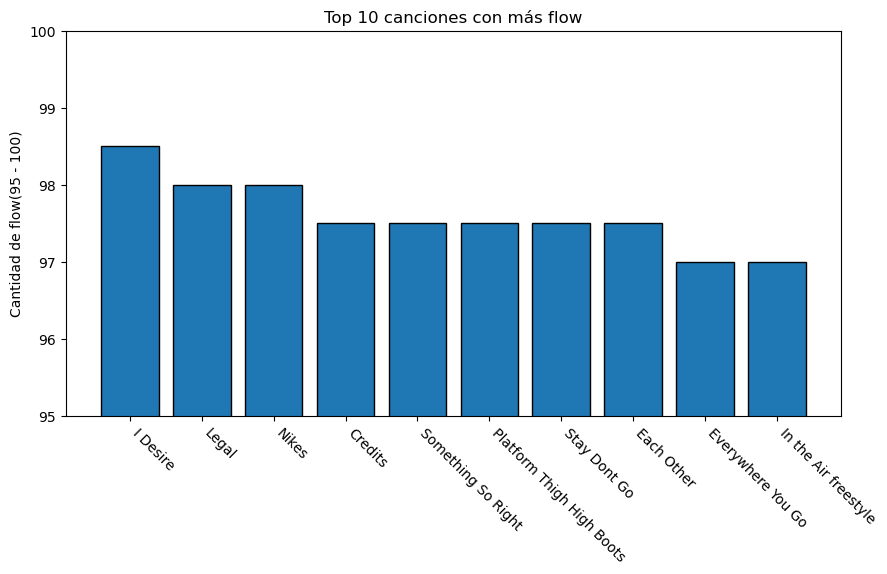

In [ ]:
# Data
songs_top_flow = get_top(unique_df, 'emotion', 'joy', 'flow', ['danceability', 'positiveness'], 10, ['song', 'flow'])

# Figura
fig = plt.figure(figsize=(10, 5))

plt.bar(songs_top_flow['song'],
        songs_top_flow['flow'],
        edgecolor='black')

plt.title('Top 10 canciones con más flow')
plt.ylabel('Cantidad de flow(95 - 100)')
plt.xticks(rotation=-45,
           horizontalalignment='left')

plt.ylim(95, 100)


plt.show()

## ¿Que artista es el que transmite más flow?

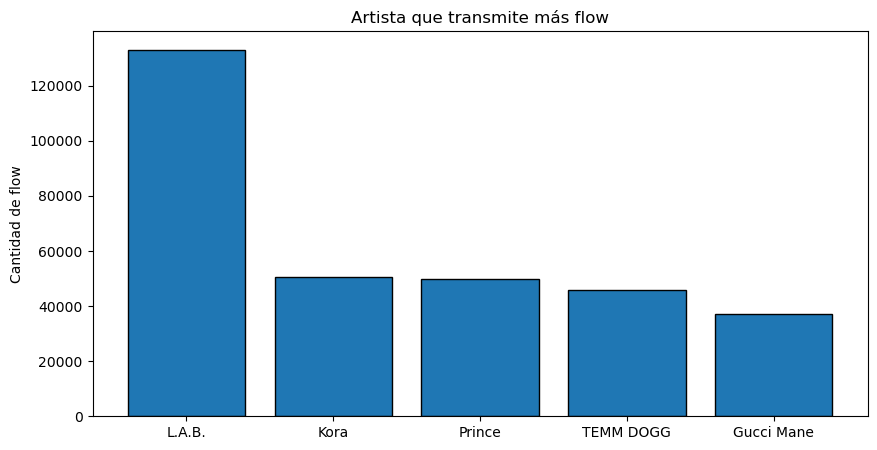

In [ ]:
# Data
artist_top_flow = artists_df[artists_df['emotion'] == 'joy'].groupby('artists')[['danceability', 'positiveness']].sum()
artist_top_flow['flow'] = artist_top_flow[['danceability', 'positiveness']].mean(axis=1)
artist_top_flow = artist_top_flow.sort_values(by='flow', ascending=False).head(5)

# Figura
fig = plt.figure(figsize=(10, 5))

plt.bar(artist_top_flow.index,
        artist_top_flow['flow'],
        edgecolor='black')

plt.title('Artista que transmite más flow')
plt.ylabel('Cantidad de flow')

plt.show()

## Clasifica el top 3 de canciones según estas categorías:

### Fiesta

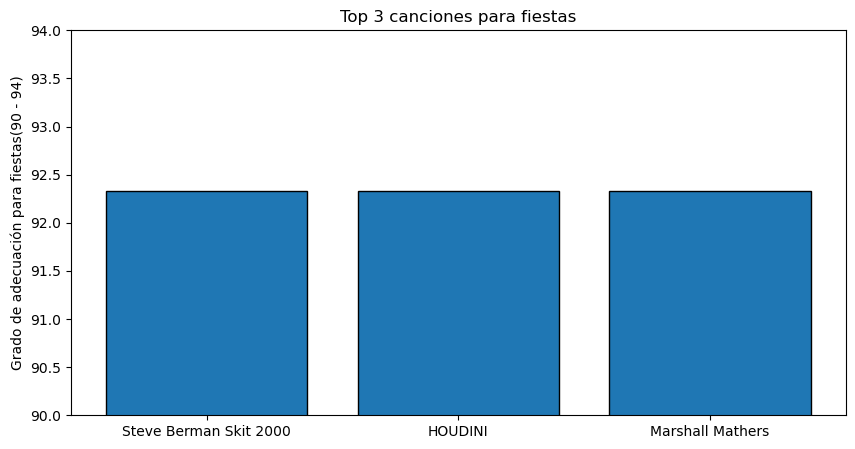

In [ ]:
# Data
party_songs = get_top(unique_df, 'good_for_party', True, 'party', ['popularity', 'energy', 'danceability'], 3, ['song', 'party'])

# figura
fig = plt.figure(figsize=(10, 5))

plt.bar(party_songs['song'],
        party_songs['party'],
        edgecolor='black')

plt.title('Top 3 canciones para fiestas')
plt.ylabel('Grado de adecuación para fiestas(90 - 94)')
plt.ylim(90, 94)


plt.show()

### Trabajo

Suponiendo que adecuado para el trabajo sea una combinación de positividad, de canciones instrumentales acústicas, donde una voz no pueda distraer a la persona.

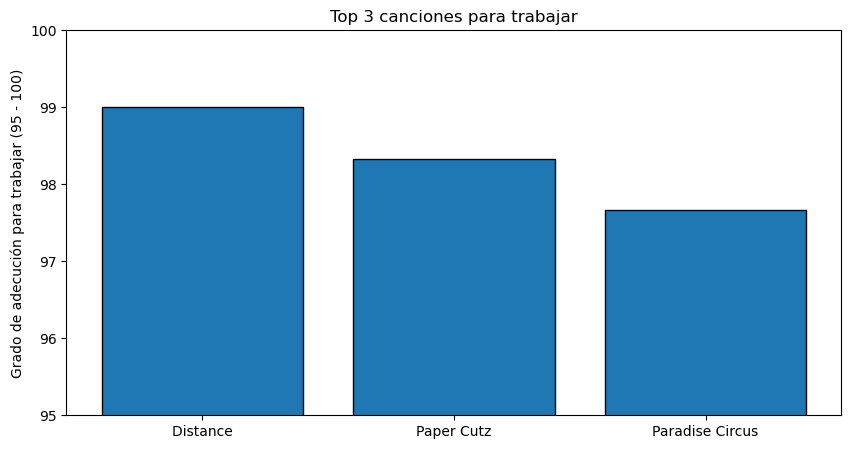

In [ ]:
# Data
work_songs = get_top(unique_df, 'good_for_work_study', True, 'work', ['positiveness', 'acousticness', 'instrumentalness'], 3, ['song', 'work'])

# Figura
fig = plt.figure(figsize=(10, 5))

plt.bar(work_songs['song'],
        work_songs['work'],
        edgecolor='black')

plt.title('Top 3 canciones para trabajar')
plt.ylabel('Grado de adecución para trabajar (95 - 100)')
plt.ylim(95, 100)

plt.show()

### Ejercicio

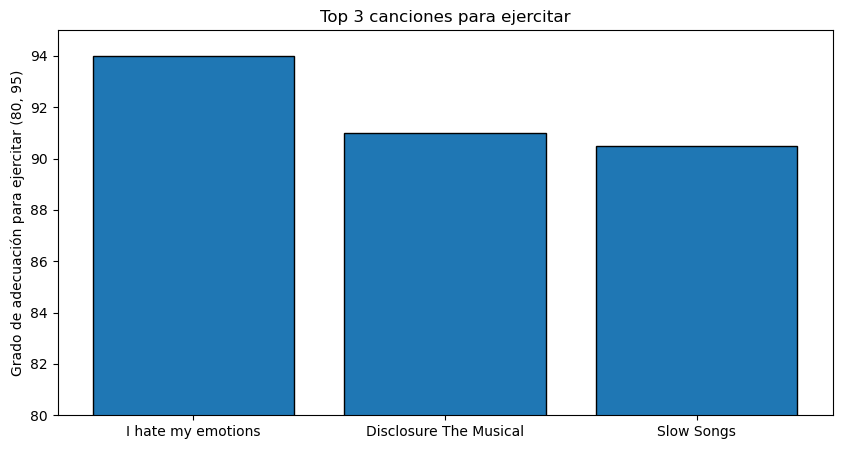

In [ ]:
# Data
work_out_songs = get_top(unique_df, 'good_for_exercise', True, 'work_out', ['energy', 'speechiness'], 3, ['song', 'work_out'])

# Figura
fig = plt.figure(figsize=(10, 5))

plt.bar(work_out_songs['song'],
        work_out_songs['work_out'],
        edgecolor='black')

plt.title('Top 3 canciones para ejercitar')
plt.ylabel('Grado de adecuación para ejercitar (80, 95)')
plt.ylim(80, 95)

plt.show()

### Relajación

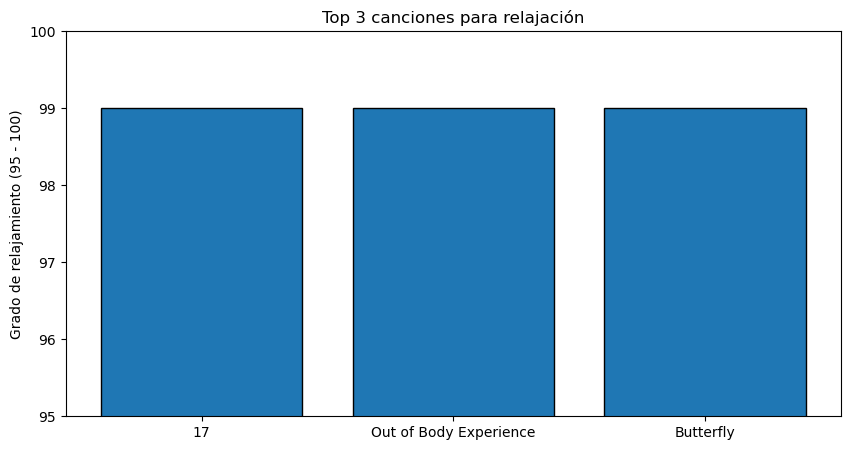

In [ ]:
# Data
relax_songs = get_top(unique_df, 'good_for_relaxation_meditation', True, 'relax', ['acousticness', 'instrumentalness'], 3, ['song', 'relax'])

# Figura
fig = plt.figure(figsize=(10, 5))

plt.bar(relax_songs['song'],
        relax_songs['relax'],
        edgecolor='black')

plt.title('Top 3 canciones para relajación')
plt.ylabel('Grado de relajamiento (95 - 100)')
plt.ylim(95, 100)

plt.show()

### Conducción

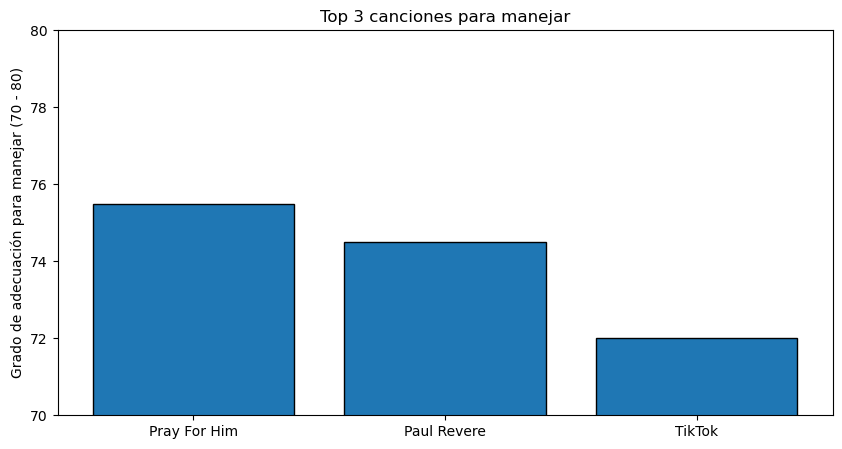

In [ ]:
# Data
driving_songs = get_top(unique_df, 'good_for_driving', True, 'driving', ['energy', 'speechiness'], 3, ['song', 'driving'])

# Figura
fig = plt.figure(figsize=(10, 5))

plt.bar(driving_songs['song'],
        driving_songs['driving'],
        edgecolor='black')

plt.title('Top 3 canciones para manejar')
plt.ylabel('Grado de adecuación para manejar (70 - 80)')
plt.ylim(70, 80)


plt.show()

## Visualizaciones:

### Cantidad de positivismo por año

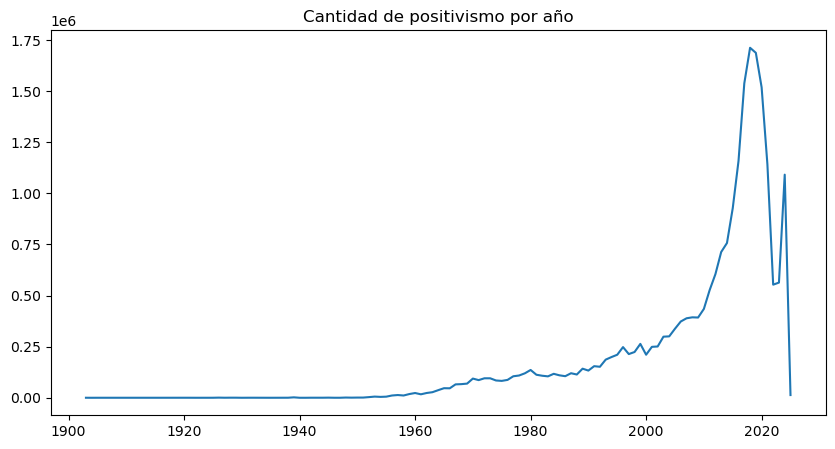

In [ ]:
# Data
positiveness_by_year = unique_df.groupby(unique_df['release_date'].dt.year)['positiveness'].sum()
positiveness_by_year = positiveness_by_year[positiveness_by_year.index >= 1903]


# Figura
fig = plt.figure(figsize=(10, 5))

plt.plot(positiveness_by_year.index,
         positiveness_by_year.values)

plt.title('Cantidad de positivismo por año')

plt.show()

### Cantidad de canciones por año y género

C:\Users\facun\AppData\Local\Temp\ipykernel_20120\1001345210.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Género', bbox_to_anchor=(1.05, 1), loc='upper left')


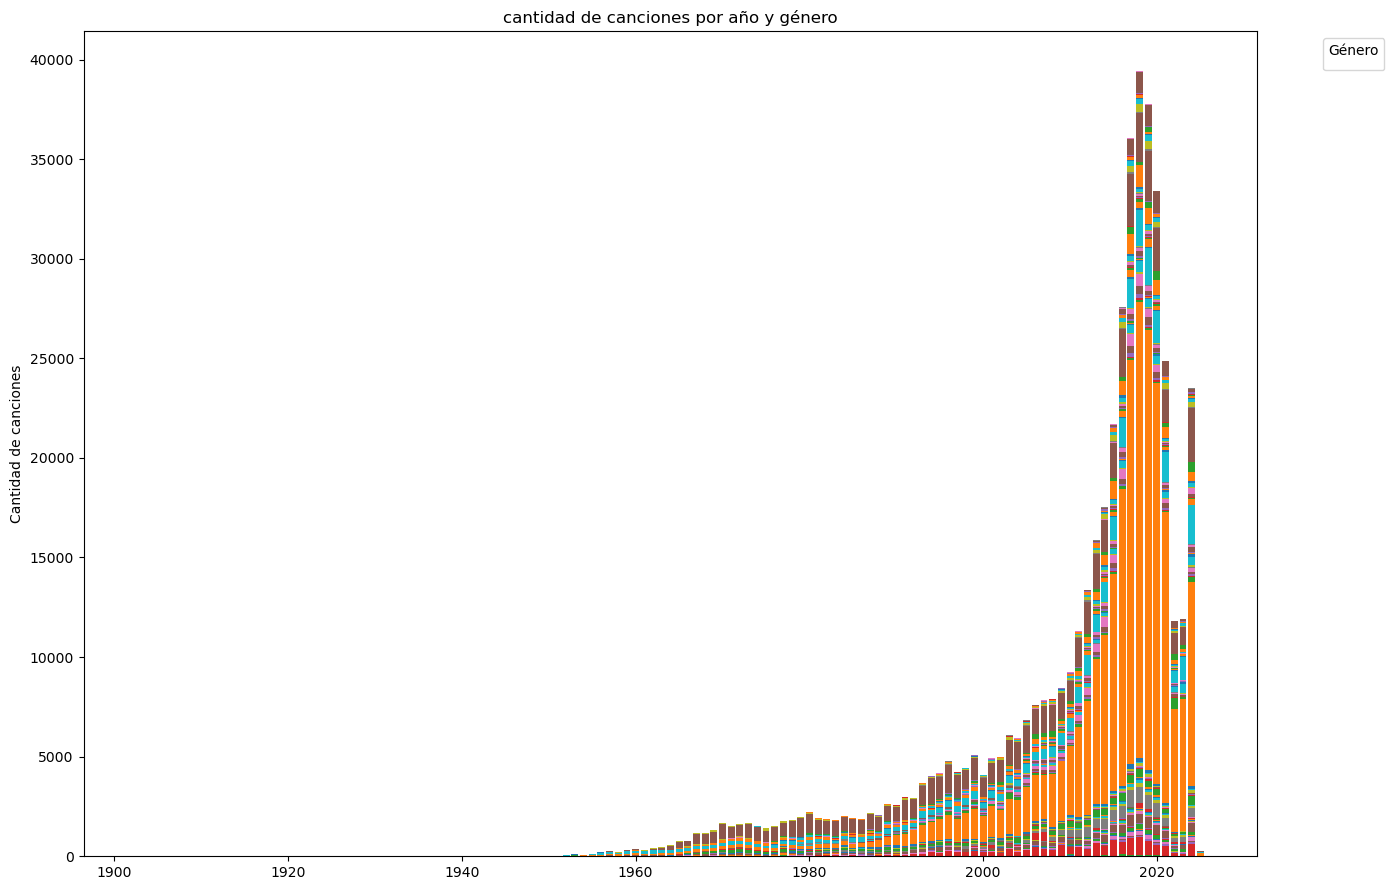

In [ ]:
year_genre = unique_df.groupby([unique_df['release_date'].dt.year, unique_df['genre']]).size().reset_index(name='count')
year_genre = year_genre.pivot_table(index='release_date', columns='genre', values='count', fill_value=0)
year_genre = year_genre[year_genre.index >= 1903]

fig, ax = plt.subplots(figsize=(14, 9))

bottom = np.zeros(len(year_genre))

for genre in year_genre.columns:
  ax.bar(year_genre.index, year_genre[genre], bottom=bottom)
  bottom += year_genre[genre]

ax.set_title('cantidad de canciones por año y género')
ax.set_ylabel('Cantidad de canciones')
ax.legend(title='Género', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()

# Extra Challenge

## OSEMN

### Obtain

In [ ]:
# Definir data a usar en el modelo, eliminando las fechas utilizadas como "Desconocido"
data = unique_df[unique_df['release_date'].dt.year >= 1900]

# Definir data con los valores outliers clipeados
data_clipped = data.copy()

for column, (lower, upper) in bounds.items():
  data_clipped[column] = data_clipped[column].clip(lower=lower, upper=upper)

### Scrub

#### Data Cleaning

Ya fue verificado que no haya datos dupllicados o valores NaN, así como que no haya errores estructurales y fueron manejados los outliers

#### Data Manipulation

In [ ]:
#Eliminar columnas que no van a ser utilizadas en el modelo

unneeded_columns = ['artists', 'song', 'text', 'album',
                    'similar_artist_1', 'similar_song_1', 'similarity_score_1',
                    'similar_artist_2', 'similar_song_2', 'similarity_score_2',
                    'similar_artist_3', 'similar_song_3', 'similarity_score_3']

data = data.drop(columns=unneeded_columns)
data_clipped = data_clipped.drop(columns=unneeded_columns)

In [ ]:
# Tranformar 'lenght' a segundos para que sea numérica

data['length'] = data['length'].dt.total_seconds()
data_clipped['length'] = data_clipped['length'].dt.total_seconds()

In [ ]:
# Tranformar 'release_date' en columnas 'release_year' y 'releas_month' para que sea numéricas

data['release_year'] = data['release_date'].dt.year
data['release_month'] = data['release_date'].dt.month
data = data.drop(columns='release_date')

data_clipped['release_year'] = data_clipped['release_date'].dt.year
data_clipped['release_month'] = data_clipped['release_date'].dt.month
data_clipped = data_clipped.drop(columns='release_date')

### Explore/Model

La etapa de explore se realiza dentro del mismo pipeline en el que se entrena el modelo de clasificación

In [ ]:
# Definir variables X e y, y separar en entrenamiento y test
X = data.drop(columns=['genre'])
y = data['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

# Definir variables X_clipped e y_clipped, y separar en entrenamiento y test
X_clipped = data_clipped.drop(columns=['genre'])
y_clipped = data_clipped['genre']
X_train_clipped, X_test_clipped, y_train_clipped, y_test_clipped = train_test_split(X_clipped, y_clipped, random_state=42, test_size=0.3, stratify=y_clipped)

In [ ]:
# Definir columnas categóricas a codificar
categorical_columns = ['emotion', 'key', 'time_signature']

In [ ]:
# Definir preprocesador
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
], remainder='passthrough')

In [ ]:
# Definir Pipeline
pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('feature_selection', SelectFromModel(estimator=RandomForestClassifier(random_state=42))),
    ('clf', RandomForestClassifier(random_state=42))
])

In [ ]:
# Establecer grilla de parámetros a probar
param_grid= {
    'feature_selection__estimator__n_estimators': [50],
    'feature_selection__estimator__max_depth': [5, 10, 15],
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [5, 10, 15]
}

In [ ]:
model_path = 'data_flow_model.joblib'

# Intentar cargar archivo
if os.path.exists(model_path):

  search = load(model_path)
  print('Modelo cargado desde archivo')

# Entrenar modelo y guardar en archivo
else:
  search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=1, verbose=2)
  search.fit(X_train, y_train)
  dump(search, model_path)
  print('Modelo entrenado y guardado en archivo')

Modelo cargado desde archivo


In [ ]:
model_clipped_path = 'data_flow_clipped_model.joblib'

# Intentar cargar archivo
if os.path.exists(model_clipped_path):

  search_clipped = load(model_clipped_path)
  print('Modelo sin outliers cargado desde archivo')

# Entrenar modelo y guardar archivo
else:
  search_clipped = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=1, verbose=2)
  search_clipped.fit(X_train_clipped, y_train_clipped)
  dump(search_clipped, model_clipped_path)
  print('Modelo sin outliers entrenado y guardado en archivo')

Modelo sin outliers cargado desde archivo


In [ ]:
# Predecir X_test
y_pred = search.predict(X_test)
y_proba = search.predict_proba(X_test)

# Predecir X_test_clipped
y_clipped_pred = search_clipped.predict(X_test_clipped)
y_clipped_proba = search_clipped.predict_proba(X_test_clipped)

### iNterpret

In [ ]:
clf = search.best_estimator_.named_steps['clf']
importances = clf.feature_importances_
features = X_test.columns

top_n = 5
top_features = features[importances.argsort()[::-1][:top_n]].tolist()

In [ ]:
rfc_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_test, average='weighted'),
    'f1': f1_score(y_test, y_pred, average='weighted'),
    'loss': log_loss(y_test, y_proba),
    'best_params': search.best_params_,
    'top_features': top_features
}

rfc_metrics = pd.DataFrame([rfc_metrics], index=['Modelo con outliers'])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
clf = search_clipped.best_estimator_.named_steps['clf']
importances = clf.feature_importances_
features = X_test_clipped.columns

top_n = 5
top_features = features[importances.argsort()[::-1][:top_n]].tolist()

In [ ]:
rfc_clipped_metrics = {
    'accuracy': accuracy_score(y_test_clipped, y_clipped_pred),
    'precision': precision_score(y_test_clipped, y_clipped_pred, average='weighted'),
    'recall': recall_score(y_test_clipped, y_clipped_pred, average='weighted'),
    'f1': f1_score(y_test_clipped, y_clipped_pred, average='weighted'),
    'loss': log_loss(y_test_clipped, y_clipped_proba),
    'best_params': search_clipped.best_params_,
    'top_features': top_features
}

rfc_clipped_metrics = pd.DataFrame([rfc_clipped_metrics], index=['Modelo sin outliers'])

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
metrics = pd.concat([rfc_metrics, rfc_clipped_metrics])
metrics

,accuracy,precision,recall,f1,loss,best_params,top_features
Modelo con outliers,0.540621,0.670236,1.000000,0.447638,1.850874,"{'clf__max_depth': 15, 'clf__n_estimators': 10...","[liveness, loudness_db, energy, explicit, tempo]"
Modelo sin outliers,0.540766,0.671262,0.540766,0.447801,1.849493,"{'clf__max_depth': 15, 'clf__n_estimators': 10...","[liveness, loudness_db, energy, explicit, tempo]"


*   Accuracy: Porcentaje de predicciones correctas sobre el total (Entre 0 y 1)
*   Precision: Porcentaje ponderado de predicciones correctas entre los casos predichos como cada clase (Entre 0 y 1)
*   Recall: Porcentaje de los datos de prueba de cada clase encontrados (Entre 0 y 1)
*   f1: Porcentaje único que combina precisión y recall equilibradamente (Entre 0 y 1)
*   Loss: Mide que tan buenas son las probabilidades que da el modelo (0 a ∞ (mayor = peor))